# 📊 NSE Stock Closing Price Prediction
**Complete end-to-end ML pipeline with data cleaning, model training, and predictions**

## Workflow
1. **Data Collection & Quality Check**
2. **Data Cleaning** (Handle missing values)
3. **Exploratory Data Analysis**
4. **Model Training** (LSTM, RNN, Prophet)
5. **Performance Evaluation**
6. **Next-Day Predictions**
7. **Results Export**

---
## Setup & Import Libraries

In [5]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv
import logging

# ML libraries
import tensorflow as tf
from prophet import Prophet

# Custom modules
from closing_price_pipeline import (
    DailyDataAggregator,
    LSTMPredictor,
    RNNPredictor,
    ProphetPredictor,
    ModelComparator
)

# Setup
load_dotenv()
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Suppress TensorFlow logs
logging.getLogger('tensorflow').setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

print("✅ Libraries loaded successfully")
print(f"   TensorFlow: {tf.__version__}")
print(f"   NumPy: {np.__version__}")
print(f"   Pandas: {pd.__version__}")

✅ Libraries loaded successfully
   TensorFlow: 2.20.0
   NumPy: 2.3.3
   Pandas: 2.3.3


---
## 1. Data Collection

In [6]:
# Database configuration
DB_CONFIG = {
    "dbname": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USER"),
    "password": os.getenv("DB_PASSWORD"),
    "host": os.getenv("DB_HOST"),
    "port": os.getenv("DB_PORT")
}

print("📡 Database Configuration:")
print(f"   Database: {DB_CONFIG['dbname']}")
print(f"   Host: {DB_CONFIG['host']}:{DB_CONFIG['port']}")

📡 Database Configuration:
   Database: nse
   Host: localhost:5432


In [7]:
# Fetch daily closing prices
print("Fetching daily closing prices from database...\n")

aggregator = DailyDataAggregator(DB_CONFIG)
df_raw = aggregator.get_daily_closing_prices(days_back=90)

print(f"📊 Raw Data Summary:")
print(f"   Total records: {len(df_raw):,}")
print(f"   Unique stocks: {df_raw['symbol'].nunique()}")
print(f"   Date range: {df_raw['trading_date'].min()} to {df_raw['trading_date'].max()}")
print(f"   Days span: {(df_raw['trading_date'].max() - df_raw['trading_date'].min()).days}")

# Display sample
df_raw.head()

Fetching daily closing prices from database...



2025-11-18 07:48:43,007 - INFO - Fetched 4304 daily records for 71 symbols


📊 Raw Data Summary:
   Total records: 4,304
   Unique stocks: 71
   Date range: 2025-08-20 to 2025-11-11
   Days span: 83


,symbol,trading_date,close_price,daily_high,daily_low,daily_volume
0,ABSA,2025-08-20,19.70,19.85,19.50,1.012184e+09
1,ABSA,2025-08-21,19.90,19.95,19.50,1.141746e+09
2,ABSA,2025-08-22,19.95,20.00,19.60,6.877035e+07
3,ABSA,2025-08-25,19.85,20.00,19.75,4.602732e+07
4,ABSA,2025-08-26,19.90,20.00,19.75,2.527318e+08


---
## 2. Data Quality Check & Cleaning

In [9]:
# Check for missing values
print("🔍 Missing Values Analysis:\n")
missing_summary = df_raw.isnull().sum()
print(missing_summary)

# Identify stocks with missing close_price
if df_raw['close_price'].isnull().sum() > 0:
    print("\n⚠️  Stocks with missing close_price values:")
    missing_by_stock = df_raw[df_raw['close_price'].isnull()].groupby('symbol').size().sort_values(ascending=False)
    print(missing_by_stock)

🔍 Missing Values Analysis:

symbol            0
trading_date      0
close_price     137
daily_high      891
daily_low       891
daily_volume      0
dtype: int64

⚠️  Stocks with missing close_price values:
symbol
SLAM-R    62
TCL-R     62
HFCK-R    13
dtype: int64


In [10]:
# CLEAN DATA: Remove records with missing close_price
print("🧹 Cleaning Data...\n")

initial_count = len(df_raw)
df_clean = df_raw[df_raw['close_price'].notna()].copy()
removed_count = initial_count - len(df_clean)

print(f"   Initial records: {initial_count:,}")
print(f"   Cleaned records: {len(df_clean):,}")
print(f"   Removed: {removed_count:,} ({(removed_count/initial_count*100):.2f}%)")

# Verify no missing close_price
assert df_clean['close_price'].isnull().sum() == 0, "Still have missing close_price!"
print("\n✅ Data cleaning complete - no missing close_price values")

🧹 Cleaning Data...

   Initial records: 4,304
   Cleaned records: 4,167
   Removed: 137 (3.18%)

✅ Data cleaning complete - no missing close_price values


---
## 3. Exploratory Data Analysis

In [12]:
# Data availability per stock
stock_counts = df_clean.groupby('symbol').size().sort_values(ascending=False)

print("📈 Stock Data Availability:\n")
print(f"   Stocks with 60+ days: {(stock_counts >= 60).sum()}")
print(f"   Stocks with 30-59 days: {((stock_counts >= 30) & (stock_counts < 60)).sum()}")
print(f"   Stocks with < 30 days: {(stock_counts < 30).sum()}")

print("\nTop 10 stocks by data availability:")
print(stock_counts.head(10))

📈 Stock Data Availability:

   Stocks with 60+ days: 67
   Stocks with 30-59 days: 0
   Stocks with < 30 days: 1

Top 10 stocks by data availability:
symbol
ABSA    62
SBIC    62
KUKZ    62
KURV    62
LAPR    62
LBTY    62
LIMT    62
LKL     62
MSC     62
NBV     62
dtype: int64


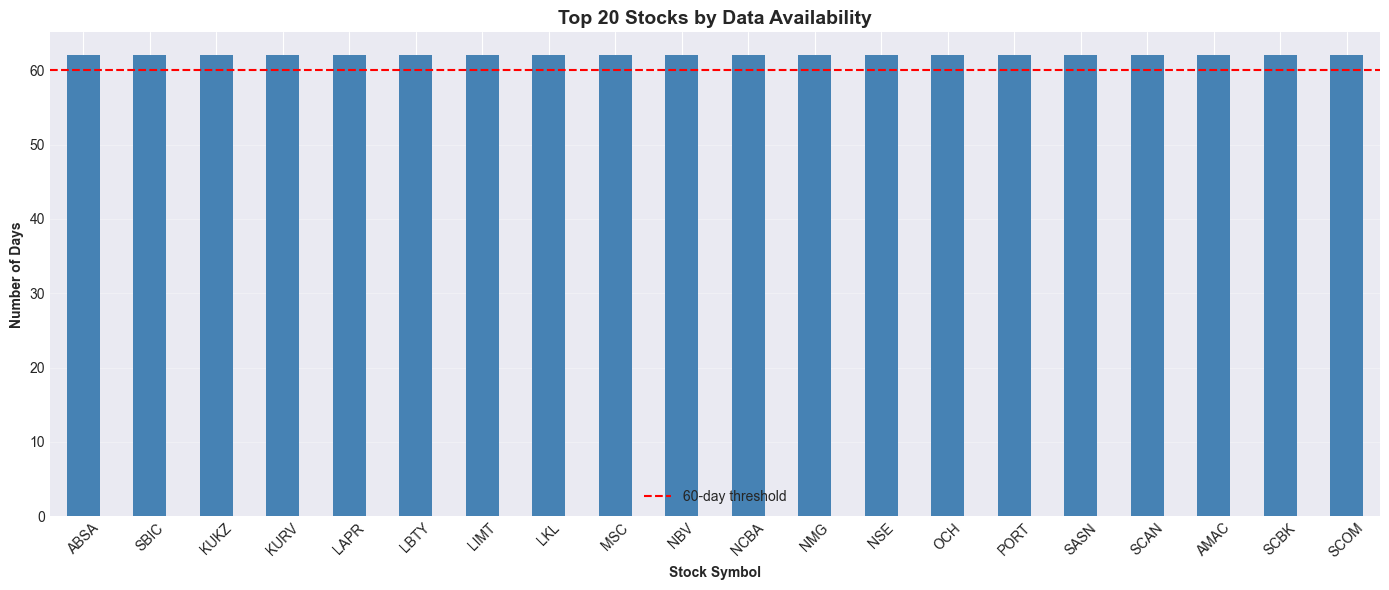

In [13]:
# Visualize data availability
plt.figure(figsize=(14, 6))
stock_counts.head(20).plot(kind='bar', color='steelblue')
plt.title('Top 20 Stocks by Data Availability', fontsize=14, fontweight='bold')
plt.xlabel('Stock Symbol', fontweight='bold')
plt.ylabel('Number of Days', fontweight='bold')
plt.axhline(y=60, color='red', linestyle='--', label='60-day threshold')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Selected stocks for detailed analysis: ['ABSA', 'SBIC', 'KUKZ', 'KURV', 'LAPR']


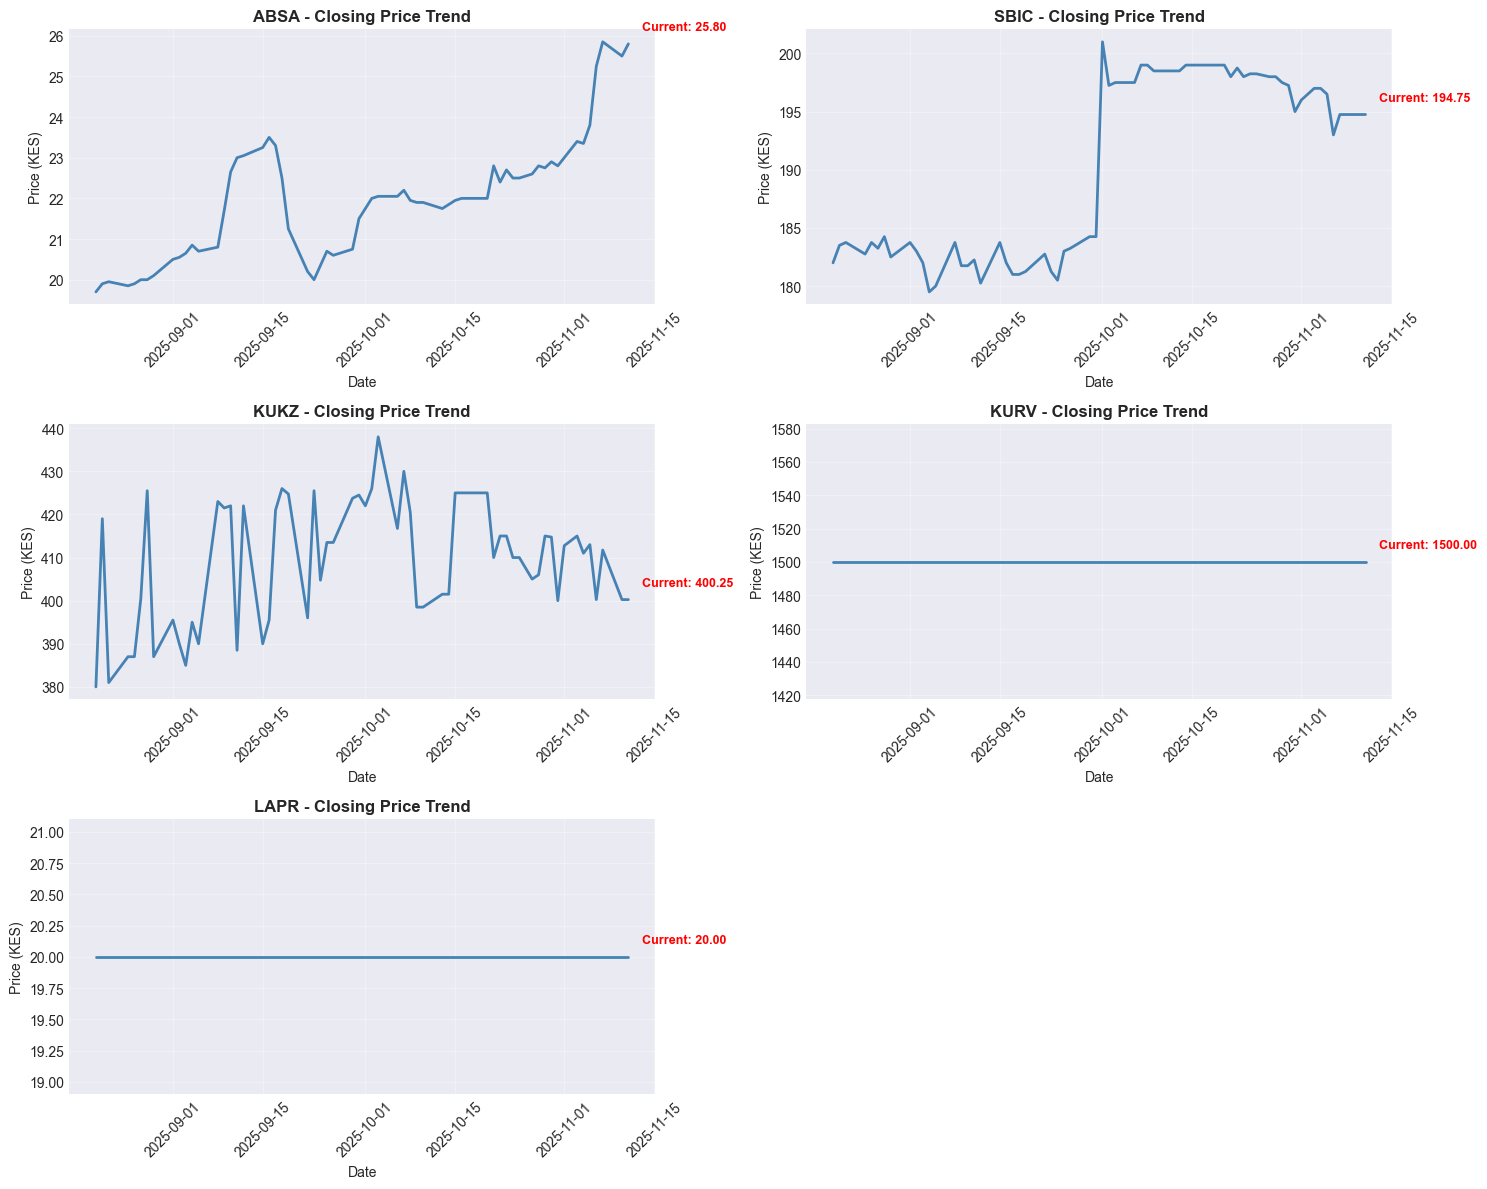

In [15]:
# Select top stocks for detailed analysis
top_stocks = stock_counts[stock_counts >= 60].head(5).index.tolist()
print(f"Selected stocks for detailed analysis: {top_stocks}")

# Plot price trends
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, symbol in enumerate(top_stocks):
    df_stock = df_clean[df_clean['symbol'] == symbol].sort_values('trading_date')
    
    axes[idx].plot(df_stock['trading_date'], df_stock['close_price'], linewidth=2, color='steelblue')
    axes[idx].set_title(f'{symbol} - Closing Price Trend', fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Price (KES)')
    axes[idx].grid(alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Add current price annotation
    current_price = df_stock['close_price'].iloc[-1]
    axes[idx].annotate(f'Current: {current_price:.2f}', 
                      xy=(df_stock['trading_date'].iloc[-1], current_price),
                      xytext=(10, 10), textcoords='offset points',
                      fontsize=9, color='red', fontweight='bold')

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

---
## 4. Model Training - Single Stock Deep Dive

In [16]:

ANALYSIS_SYMBOL = stock_counts.index[0]
df_analysis = df_clean[df_clean['symbol'] == ANALYSIS_SYMBOL].sort_values('trading_date').reset_index(drop=True)

print(f"📍 Selected Stock: {ANALYSIS_SYMBOL}")
print(f"   Data points: {len(df_analysis)}")
print(f"   Date range: {df_analysis['trading_date'].min()} to {df_analysis['trading_date'].max()}")
print(f"   Price range: {df_analysis['close_price'].min():.2f} - {df_analysis['close_price'].max():.2f} KES")
print(f"   Current price: {df_analysis['close_price'].iloc[-1]:.2f} KES")
print(f"\nRecent prices:")
df_analysis[['trading_date', 'close_price', 'daily_volume']].tail(10)

📍 Selected Stock: ABSA
   Data points: 62
   Date range: 2025-08-20 to 2025-11-11
   Price range: 19.70 - 25.85 KES
   Current price: 25.80 KES

Recent prices:


,trading_date,close_price,daily_volume
52,2025-10-30,22.90,53183992.0
53,2025-10-31,22.80,64227139.0
54,2025-11-01,23.00,233996890.0
55,2025-11-03,23.40,36900387.0
56,2025-11-04,23.35,43058768.0
57,2025-11-05,23.80,191681771.0
58,2025-11-06,25.25,187115367.0
59,2025-11-07,25.85,120181514.0
60,2025-11-10,25.50,93188349.0
61,2025-11-11,25.80,6178758.0


### 4.1 LSTM Model

In [17]:
# Train LSTM
print("🤖 Training LSTM model...\n")

lstm = LSTMPredictor(ANALYSIS_SYMBOL, lookback_days=10)
lstm_metrics, lstm_history = lstm.train(df_analysis, test_size=0.2, epochs=100, batch_size=32)

print("\n📊 LSTM Performance Metrics:")
for metric, value in lstm_metrics.items():
    print(f"   {metric}: {value:.4f}")

2025-11-18 07:54:11,047 - INFO - LSTM model built for ABSA
2025-11-18 07:54:11,048 - INFO - Training LSTM for ABSA with 41 samples...


🤖 Training LSTM model...



2025-11-18 07:54:13,422 - INFO - LSTM ABSA - RMSE: 1.32, MAE: 0.94, MAPE: 3.73%



📊 LSTM Performance Metrics:
   MSE: 1.7371
   RMSE: 1.3180
   MAE: 0.9398
   R2: -0.1584
   MAPE: 3.7324


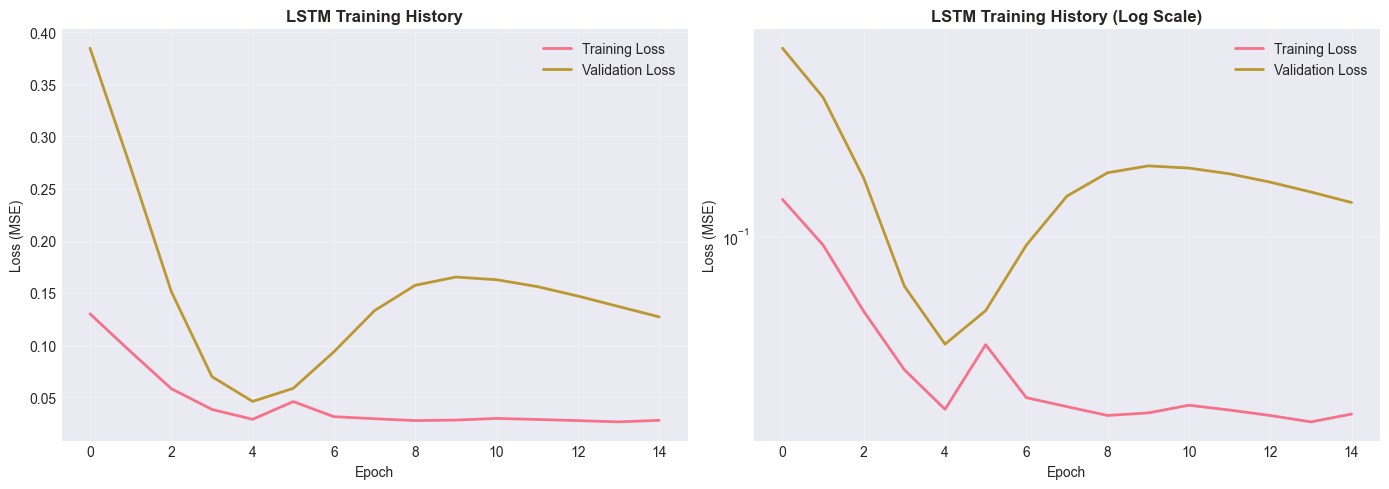

In [18]:
# Plot LSTM training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Regular scale
axes[0].plot(lstm_history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(lstm_history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('LSTM Training History', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Log scale
axes[1].plot(lstm_history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(lstm_history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('LSTM Training History (Log Scale)', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss (MSE)')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 RNN Model

In [19]:
# Train RNN
print("🤖 Training RNN model...\n")

rnn = RNNPredictor(ANALYSIS_SYMBOL, lookback_days=10)
rnn_metrics, rnn_history = rnn.train(df_analysis, test_size=0.2, epochs=100, batch_size=32)

print("\n📊 RNN Performance Metrics:")
for metric, value in rnn_metrics.items():
    print(f"   {metric}: {value:.4f}")

2025-11-18 07:54:59,733 - INFO - RNN model built for ABSA
2025-11-18 07:54:59,733 - INFO - Training RNN for ABSA with 41 samples...


🤖 Training RNN model...



2025-11-18 07:55:01,561 - INFO - RNN ABSA - RMSE: 1.74, MAE: 1.29, MAPE: 5.16%



📊 RNN Performance Metrics:
   MSE: 3.0195
   RMSE: 1.7377
   MAE: 1.2935
   R2: -1.0136
   MAPE: 5.1556


### 4.3 Prophet Model

In [20]:
# Train Prophet
print("🤖 Training Prophet model...\n")

prophet = ProphetPredictor(ANALYSIS_SYMBOL)
prophet_metrics = prophet.train(df_analysis, test_size=0.2)

print("\n📊 Prophet Performance Metrics:")
for metric, value in prophet_metrics.items():
    print(f"   {metric}: {value:.4f}")

2025-11-18 07:55:28,453 - INFO - Training Prophet for ABSA with 49 samples...
2025-11-18 07:55:28,486 - INFO - Chain [1] start processing
2025-11-18 07:55:28,584 - INFO - Chain [1] done processing
2025-11-18 07:55:28,596 - INFO - Prophet ABSA - RMSE: 1.92, MAE: 1.50, MAPE: 6.07%


🤖 Training Prophet model...


📊 Prophet Performance Metrics:
   MSE: 3.6847
   RMSE: 1.9196
   MAE: 1.5017
   R2: -1.4517
   MAPE: 6.0700


---
## 5. Model Comparison

In [21]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'LSTM': lstm_metrics,
    'RNN': rnn_metrics,
    'Prophet': prophet_metrics
}).T

print("\n" + "="*80)
print(f"MODEL PERFORMANCE COMPARISON - {ANALYSIS_SYMBOL}")
print("="*80)
print(comparison_df.to_string())
print("="*80)


MODEL PERFORMANCE COMPARISON - ABSA
              MSE      RMSE       MAE        R2      MAPE
LSTM     1.737118  1.317998  0.939803 -0.158398  3.732412
RNN      3.019515  1.737675  1.293464 -1.013565  5.155557
Prophet  3.684725  1.919564  1.501664 -1.451744  6.069993


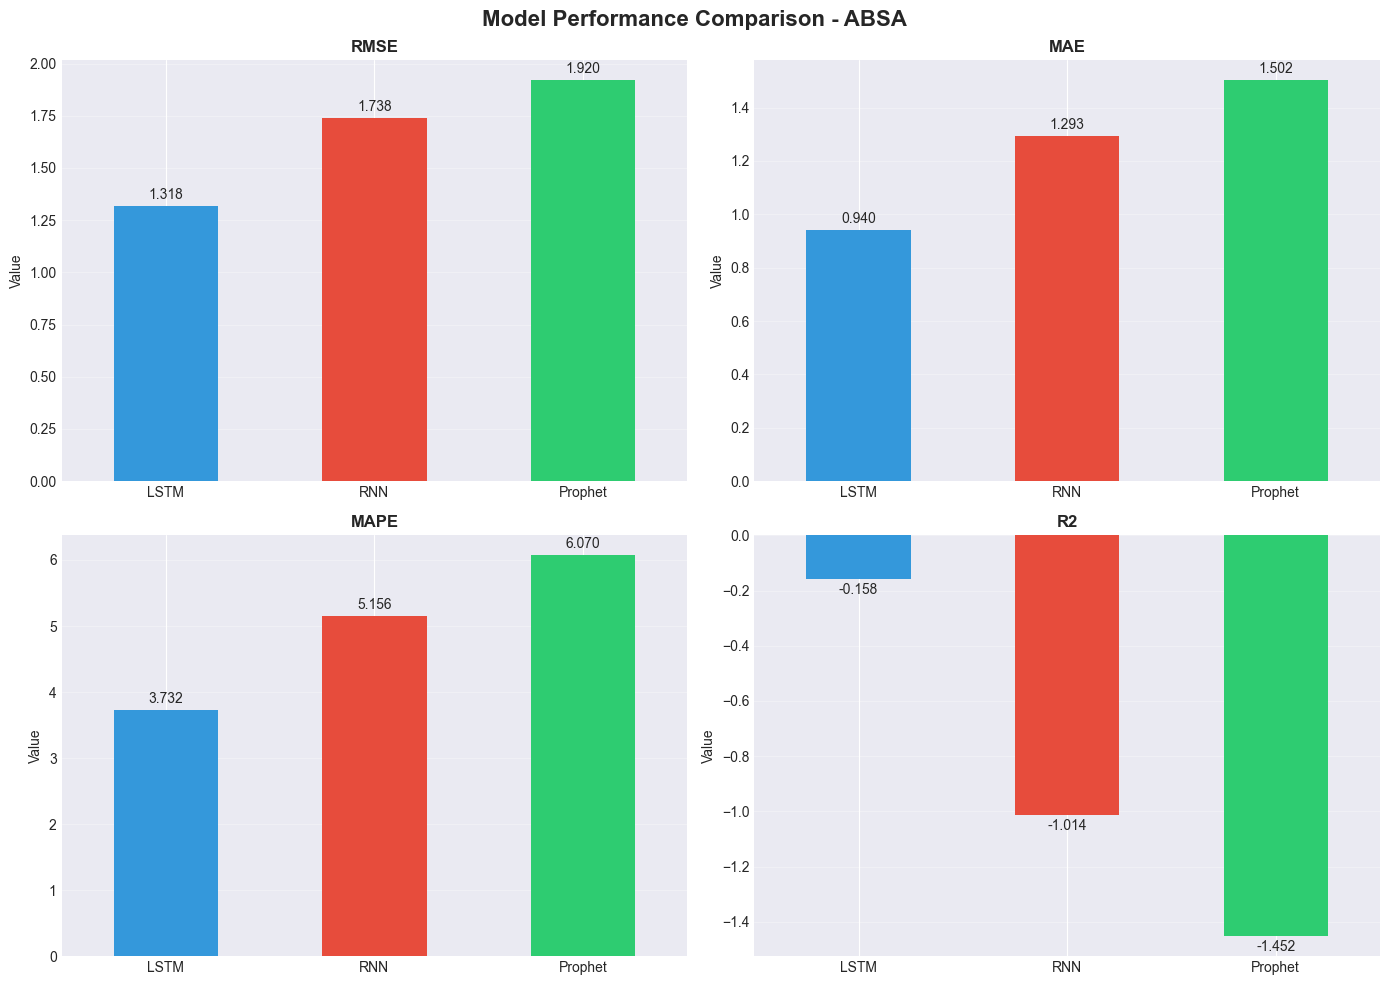

In [22]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Model Performance Comparison - {ANALYSIS_SYMBOL}', fontsize=16, fontweight='bold')

metrics = ['RMSE', 'MAE', 'MAPE', 'R2']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    comparison_df[metric].plot(kind='bar', ax=ax, color=colors)
    ax.set_title(metric, fontweight='bold', fontsize=12)
    ax.set_ylabel('Value')
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=0)
    
    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()

---
## 6. Next-Day Predictions

In [23]:
# Make predictions
lstm_pred = lstm.predict_next_day(df_analysis)
rnn_pred = rnn.predict_next_day(df_analysis)
prophet_pred = prophet.predict_next_day(df_analysis)

current_price = df_analysis['close_price'].iloc[-1]
ensemble_pred = np.mean([lstm_pred, rnn_pred, prophet_pred])

print("\n" + "="*80)
print(f"{ANALYSIS_SYMBOL} - NEXT DAY CLOSING PRICE PREDICTIONS")
print("="*80)
print(f"\nCurrent Price (Last Trading Day): {current_price:.2f} KES")
print(f"\nIndividual Model Predictions:")
print(f"   LSTM:    {lstm_pred:.2f} KES ({((lstm_pred/current_price - 1)*100):+.2f}%)")
print(f"   RNN:     {rnn_pred:.2f} KES ({((rnn_pred/current_price - 1)*100):+.2f}%)")
print(f"   Prophet: {prophet_pred:.2f} KES ({((prophet_pred/current_price - 1)*100):+.2f}%)")
print(f"\nEnsemble (Average): {ensemble_pred:.2f} KES ({((ensemble_pred/current_price - 1)*100):+.2f}%)")
print("="*80)


ABSA - NEXT DAY CLOSING PRICE PREDICTIONS

Current Price (Last Trading Day): 25.80 KES

Individual Model Predictions:
   LSTM:    23.82 KES (-7.68%)
   RNN:     22.78 KES (-11.69%)
   Prophet: 22.55 KES (-12.59%)

Ensemble (Average): 23.05 KES (-10.65%)


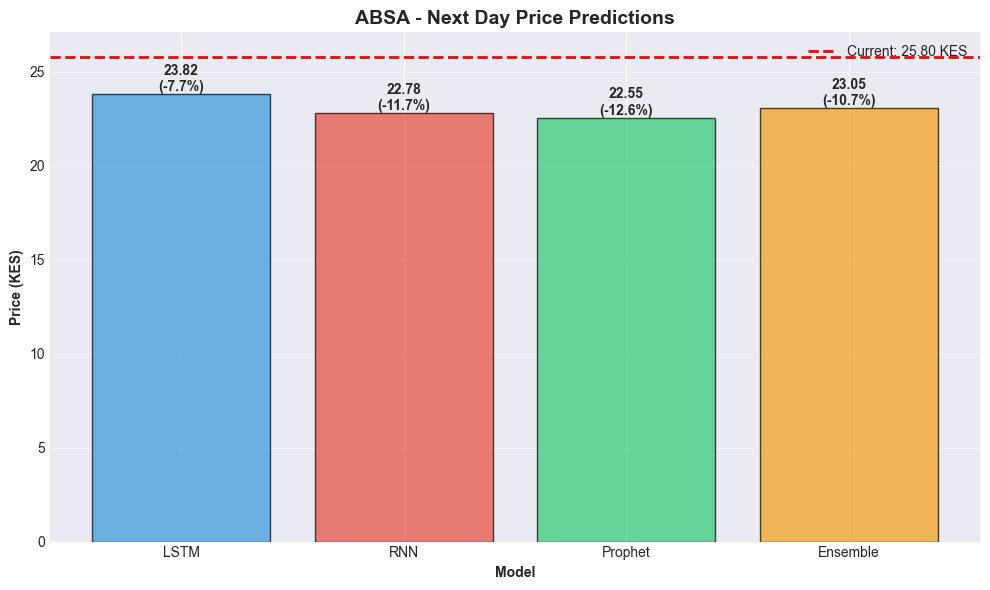

In [24]:
# Visualize predictions
predictions = [lstm_pred, rnn_pred, prophet_pred, ensemble_pred]
labels = ['LSTM', 'RNN', 'Prophet', 'Ensemble']
colors_pred = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

fig, ax = plt.subplots(figsize=(10, 6))

# Bar chart
bars = ax.bar(labels, predictions, color=colors_pred, alpha=0.7, edgecolor='black')
ax.axhline(y=current_price, color='red', linestyle='--', linewidth=2, label=f'Current: {current_price:.2f} KES')

ax.set_title(f'{ANALYSIS_SYMBOL} - Next Day Price Predictions', fontsize=14, fontweight='bold')
ax.set_ylabel('Price (KES)', fontweight='bold')
ax.set_xlabel('Model', fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar, pred in zip(bars, predictions):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{pred:.2f}\n({((pred/current_price - 1)*100):+.1f}%)',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

---
## 7. Multi-Stock Analysis

In [25]:
# Process multiple stocks
stocks_to_process = stock_counts[stock_counts >= 60].head(5).index.tolist()
print(f"Processing {len(stocks_to_process)} stocks with 60+ days of data...\n")
print(stocks_to_process)

# Initialize comparator
comparator = ModelComparator()

# Process each stock
for idx, symbol in enumerate(stocks_to_process, 1):
    print(f"\n[{idx}/{len(stocks_to_process)}] Processing {symbol}...")
    
    df_stock = df_clean[df_clean['symbol'] == symbol].sort_values('trading_date').reset_index(drop=True)
    
    try:
        # LSTM
        lstm_model = LSTMPredictor(symbol, lookback_days=10)
        lstm_m, _ = lstm_model.train(df_stock, test_size=0.2, epochs=50, batch_size=32)
        lstm_p = lstm_model.predict_next_day(df_stock)
        comparator.add_result(symbol, 'LSTM', lstm_m, lstm_p)
        
        # RNN
        rnn_model = RNNPredictor(symbol, lookback_days=10)
        rnn_m, _ = rnn_model.train(df_stock, test_size=0.2, epochs=50, batch_size=32)
        rnn_p = rnn_model.predict_next_day(df_stock)
        comparator.add_result(symbol, 'RNN', rnn_m, rnn_p)
        
        # Prophet
        prophet_model = ProphetPredictor(symbol)
        prophet_m = prophet_model.train(df_stock, test_size=0.2)
        prophet_p = prophet_model.predict_next_day(df_stock)
        comparator.add_result(symbol, 'Prophet', prophet_m, prophet_p)
        
        current = df_stock['close_price'].iloc[-1]
        print(f"   ✅ Current: {current:.2f} | LSTM: {lstm_p:.2f} | RNN: {rnn_p:.2f} | Prophet: {prophet_p:.2f}")
        
    except Exception as e:
        print(f"   ❌ Error: {str(e)}")
        continue

print("\n✅ Multi-stock analysis complete!")

2025-11-18 07:58:33,846 - INFO - LSTM model built for ABSA
2025-11-18 07:58:33,847 - INFO - Training LSTM for ABSA with 41 samples...


Processing 5 stocks with 60+ days of data...

['ABSA', 'SBIC', 'KUKZ', 'KURV', 'LAPR']

[1/5] Processing ABSA...


2025-11-18 07:58:36,127 - INFO - LSTM ABSA - RMSE: 1.38, MAE: 0.98, MAPE: 3.88%
2025-11-18 07:58:36,297 - INFO - RNN model built for ABSA
2025-11-18 07:58:36,298 - INFO - Training RNN for ABSA with 41 samples...
2025-11-18 07:58:38,116 - INFO - RNN ABSA - RMSE: 1.56, MAE: 1.20, MAPE: 4.85%
2025-11-18 07:58:38,244 - INFO - Training Prophet for ABSA with 49 samples...
2025-11-18 07:58:38,250 - INFO - Chain [1] start processing
2025-11-18 07:58:38,321 - INFO - Chain [1] done processing
2025-11-18 07:58:38,332 - INFO - Prophet ABSA - RMSE: 1.92, MAE: 1.50, MAPE: 6.07%
2025-11-18 07:58:38,359 - INFO - LSTM model built for SBIC
2025-11-18 07:58:38,359 - INFO - Training LSTM for SBIC with 41 samples...


   ✅ Current: 25.80 | LSTM: 23.69 | RNN: 23.43 | Prophet: 22.55

[2/5] Processing SBIC...


2025-11-18 07:58:40,787 - INFO - LSTM SBIC - RMSE: 1.15, MAE: 0.96, MAPE: 0.49%
2025-11-18 07:58:40,957 - INFO - RNN model built for SBIC
2025-11-18 07:58:40,957 - INFO - Training RNN for SBIC with 41 samples...
2025-11-18 07:58:42,907 - INFO - RNN SBIC - RMSE: 1.26, MAE: 1.04, MAPE: 0.53%
2025-11-18 07:58:43,038 - INFO - Training Prophet for SBIC with 49 samples...
2025-11-18 07:58:43,043 - INFO - Chain [1] start processing
2025-11-18 07:58:43,127 - INFO - Chain [1] done processing
2025-11-18 07:58:43,139 - INFO - Prophet SBIC - RMSE: 3.74, MAE: 3.35, MAPE: 1.71%
2025-11-18 07:58:43,166 - INFO - LSTM model built for KUKZ
2025-11-18 07:58:43,167 - INFO - Training LSTM for KUKZ with 41 samples...


   ✅ Current: 194.75 | LSTM: 194.73 | RNN: 194.36 | Prophet: 200.64

[3/5] Processing KUKZ...


2025-11-18 07:58:45,419 - INFO - LSTM KUKZ - RMSE: 6.17, MAE: 5.68, MAPE: 1.40%
2025-11-18 07:58:45,590 - INFO - RNN model built for KUKZ
2025-11-18 07:58:45,590 - INFO - Training RNN for KUKZ with 41 samples...
2025-11-18 07:58:47,739 - INFO - RNN KUKZ - RMSE: 7.16, MAE: 5.36, MAPE: 1.33%
2025-11-18 07:58:47,870 - INFO - Training Prophet for KUKZ with 49 samples...
2025-11-18 07:58:47,875 - INFO - Chain [1] start processing
2025-11-18 07:58:47,941 - INFO - Chain [1] done processing
2025-11-18 07:58:47,952 - INFO - Prophet KUKZ - RMSE: 10.19, MAE: 8.40, MAPE: 2.08%


   ✅ Current: 400.25 | LSTM: 407.90 | RNN: 413.50 | Prophet: 417.13

[4/5] Processing KURV...


2025-11-18 07:58:48,171 - INFO - LSTM model built for KURV
2025-11-18 07:58:48,171 - INFO - Training LSTM for KURV with 41 samples...
2025-11-18 07:58:50,321 - INFO - LSTM KURV - RMSE: 0.00, MAE: 0.00, MAPE: 0.00%
2025-11-18 07:58:50,489 - INFO - RNN model built for KURV
2025-11-18 07:58:50,490 - INFO - Training RNN for KURV with 41 samples...
2025-11-18 07:58:52,264 - INFO - RNN KURV - RMSE: 0.00, MAE: 0.00, MAPE: 0.00%
2025-11-18 07:58:52,395 - INFO - Training Prophet for KURV with 49 samples...
2025-11-18 07:58:52,407 - INFO - Prophet KURV - RMSE: 0.00, MAE: 0.00, MAPE: 0.00%
2025-11-18 07:58:52,432 - INFO - LSTM model built for LAPR
2025-11-18 07:58:52,432 - INFO - Training LSTM for LAPR with 41 samples...


   ✅ Current: 1500.00 | LSTM: 1500.00 | RNN: 1500.00 | Prophet: 1500.00

[5/5] Processing LAPR...


2025-11-18 07:58:54,597 - INFO - LSTM LAPR - RMSE: 0.00, MAE: 0.00, MAPE: 0.00%
2025-11-18 07:58:54,773 - INFO - RNN model built for LAPR
2025-11-18 07:58:54,774 - INFO - Training RNN for LAPR with 41 samples...
2025-11-18 07:58:56,578 - INFO - RNN LAPR - RMSE: 0.00, MAE: 0.00, MAPE: 0.00%
2025-11-18 07:58:56,913 - INFO - Training Prophet for LAPR with 49 samples...
2025-11-18 07:58:56,924 - INFO - Prophet LAPR - RMSE: 0.00, MAE: 0.00, MAPE: 0.00%


   ✅ Current: 20.00 | LSTM: 20.00 | RNN: 20.00 | Prophet: 20.00

✅ Multi-stock analysis complete!


---
## 8. Results Summary

In [26]:
# Get results
results_df = comparator.get_comparison_df()

print("\n" + "="*100)
print("FINAL RESULTS SUMMARY - ALL STOCKS")
print("="*100)
print(results_df.to_string(index=False))
print("="*100)


FINAL RESULTS SUMMARY - ALL STOCKS
symbol   model  prediction        MSE      RMSE      MAE        R2     MAPE
  ABSA    LSTM   23.689653   1.907668  1.381183 0.977165 -0.272129 3.875833
  ABSA     RNN   23.432459   2.431780  1.559416 1.204464 -0.621633 4.847755
  ABSA Prophet   22.552530   3.684725  1.919564 1.501664 -1.451744 6.069993
  SBIC    LSTM  194.726120   1.322976  1.150207 0.956356  0.278918 0.488762
  SBIC     RNN  194.362915   1.599152  1.264576 1.044911  0.128390 0.533624
  SBIC Prophet  200.635536  14.005196  3.742352 3.348337 -5.371139 1.713654
  KUKZ    LSTM  407.903870  38.038503  6.167536 5.676558  0.080594 1.397807
  KUKZ     RNN  413.503174  51.234306  7.157814 5.355818 -0.238353 1.326336
  KUKZ Prophet  417.133030 103.834303 10.189912 8.396637 -1.864102 2.077684
  KURV    LSTM 1500.000000   0.000000  0.000000 0.000000  1.000000 0.000000
  KURV     RNN 1500.000000   0.000000  0.000000 0.000000  1.000000 0.000000
  KURV Prophet 1500.000000   0.000000  0.000000 0.00

In [27]:
# Average performance by model
avg_performance = results_df.groupby('model')[['RMSE', 'MAE', 'MAPE', 'R2']].mean()

print("\n📊 Average Performance Across All Stocks:\n")
print(avg_performance.to_string())

# Find best model
best_rmse = avg_performance['RMSE'].idxmin()
best_r2 = avg_performance['R2'].idxmax()

print(f"\n🏆 Best Model by RMSE: {best_rmse} ({avg_performance.loc[best_rmse, 'RMSE']:.4f})")
print(f"🏆 Best Model by R²:   {best_r2} ({avg_performance.loc[best_r2, 'R2']:.4f})")


📊 Average Performance Across All Stocks:

             RMSE       MAE      MAPE        R2
model                                          
LSTM     1.739785  1.522016  1.152480  0.417477
Prophet  3.170365  2.649328  1.972266 -1.337397
RNN      1.996361  1.521039  1.341543  0.253681

🏆 Best Model by RMSE: LSTM (1.7398)
🏆 Best Model by R²:   LSTM (0.4175)


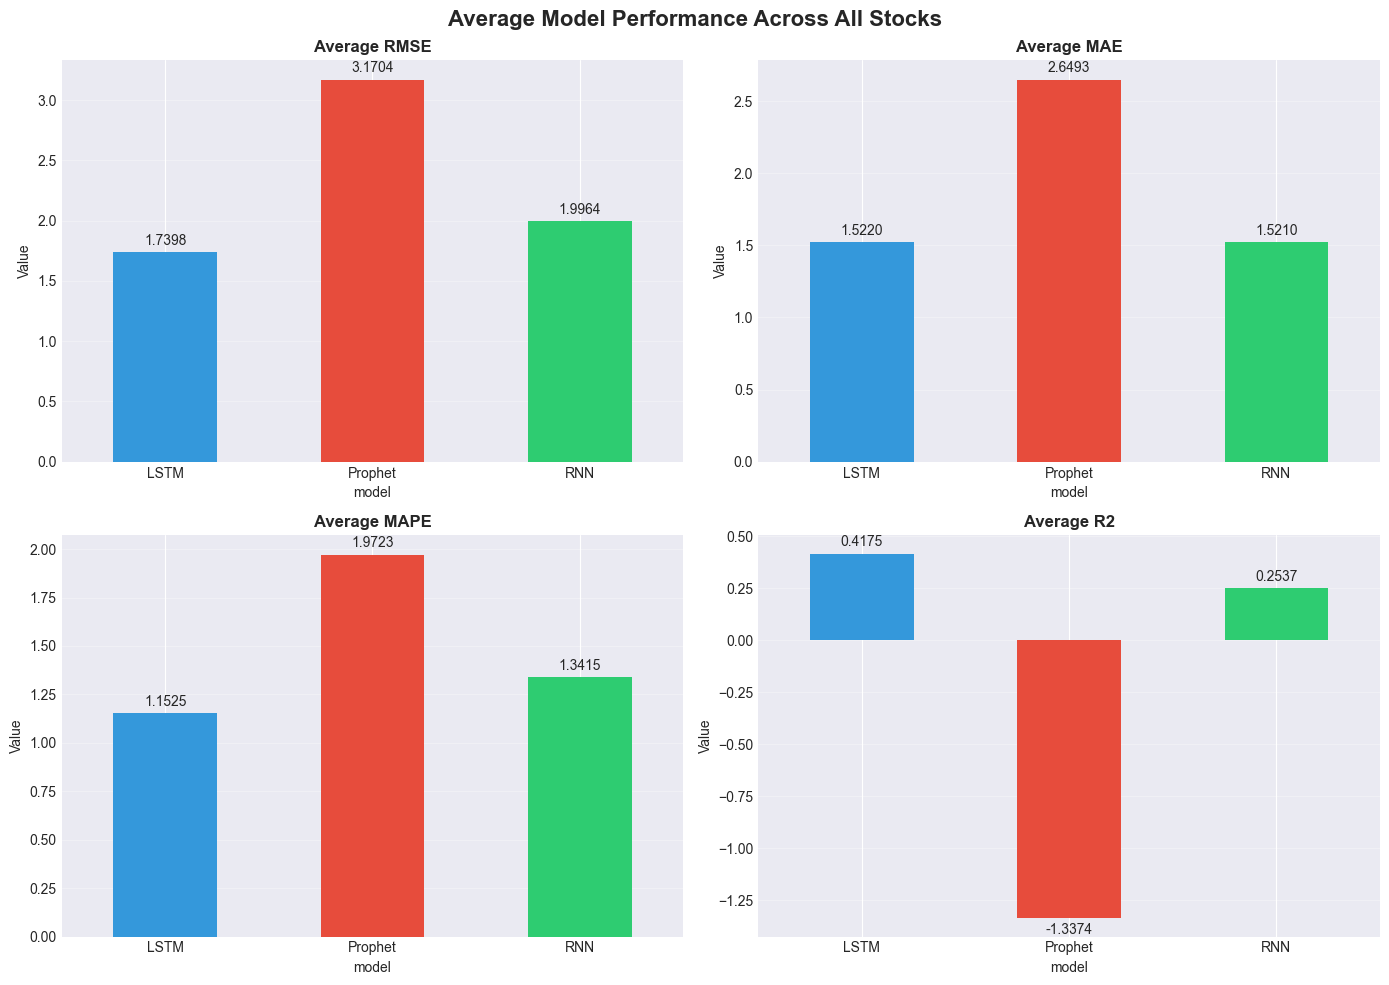

In [28]:
# Visualize average performance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Average Model Performance Across All Stocks', fontsize=16, fontweight='bold')

metrics = ['RMSE', 'MAE', 'MAPE', 'R2']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    avg_performance[metric].plot(kind='bar', ax=ax, color=colors)
    ax.set_title(f'Average {metric}', fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=0)
    
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f', padding=3)

plt.tight_layout()
plt.show()

---
## 9. Export Results

In [29]:
# Create output directory
os.makedirs('results', exist_ok=True)

# Save results
results_df.to_csv('results/model_comparison.csv', index=False)
avg_performance.to_csv('results/average_performance.csv')

# Create predictions summary
predictions_df = results_df[['symbol', 'model', 'prediction']].pivot(
    index='symbol', columns='model', values='prediction'
)
predictions_df['Ensemble'] = predictions_df.mean(axis=1)
predictions_df.to_csv('results/predictions_summary.csv')

print("✅ Results exported successfully!\n")
print("Files created:")
print("   📄 results/model_comparison.csv")
print("   📄 results/average_performance.csv")
print("   📄 results/predictions_summary.csv")

print("\nPredictions Summary:")
print(predictions_df)

✅ Results exported successfully!

Files created:
   📄 results/model_comparison.csv
   📄 results/average_performance.csv
   📄 results/predictions_summary.csv

Predictions Summary:
model          LSTM      Prophet          RNN     Ensemble
symbol                                                    
ABSA      23.689653    22.552530    23.432459    23.224881
KUKZ     407.903870   417.133030   413.503174   412.846691
KURV    1500.000000  1500.000000  1500.000000  1500.000000
LAPR      20.000000    20.000000    20.000000    20.000000
SBIC     194.726120   200.635536   194.362915   196.574857
